# Importing Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import gc

# Connection to drive

In [2]:
try:
    from google.colab import drive
    IN_COLAB = True
    print("Running on Google Colab. ")
except:
    IN_COLAB = False
    print("Not running on Google Colab. ")

Not running on Google Colab. 


In [3]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')

In [4]:
if IN_COLAB:
    os.chdir('/content/gdrive/MyDrive/Tesi/dataset')
else:
    os.chdir('./dataset')

# Downloading, Reading and Merging Data

In [5]:
def move_directories(orig_path, dest_path):
    # Check if the destination folder exists, otherwise create it
    if not os.path.exists(dest_path):
        os.makedirs(dest_path)
    
    # Iter over all files and folders in the source directory
    for item in os.listdir(orig_path):
        orig_item_path = os.path.join(orig_path, item)
        
        # Check if it is a folder
        if os.path.isdir(orig_item_path):
            # Defines the destination path for the folder
            dest_item_path = os.path.join(dest_path, item)
            
            # Move the folder by renaming it
            os.rename(orig_item_path, dest_item_path)
            print(f"Moved directory: {orig_item_path} -> {dest_item_path}")

In [6]:
import kagglehub

# Check if some subdirectories are not empty
path_to_check = "./LUFlow/"
subdirs = [d for d in os.listdir(path_to_check) if os.path.isdir(os.path.join(path_to_check, d))]
non_empty_subdirs = [d for d in subdirs if os.listdir(os.path.join(path_to_check, d))]

dest_path = './LUFlow'

if non_empty_subdirs:
    print("Non-empty subdirectories:", non_empty_subdirs)
    print("Skip downloading.")
else:
    print("All subdirectories are empty.")
    print("Download dataset.")

    # Download latest version
    path = kagglehub.dataset_download("mryanm/luflow-network-intrusion-detection-data-set")

    print("Path to dataset files:", path)

    move_directories(path, dest_path)

Non-empty subdirectories: ['GranuleData', '2021', '2020', '2022', 'GranulatedData_300_complete', 'GranulatedData_32']
Skip downloading.


/home/ubdeskiovaro/anaconda3/envs/thesis/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
encoded_dataset = './LUFlow/encoded_dataset.csv'

if os.path.isfile(encoded_dataset):
    print("Encoded dataset is in the directory.")
    ENCODED = True
else:
    print("Encoded dataset is not in the directory.")
    ENCODED = False

Encoded dataset is in the directory.


In [8]:
if not ENCODED:

    df_list = []
    i = 0

    selected_columns = ['bytes_in', 'bytes_out', 'num_pkts_out', 'num_pkts_in', 'proto', 'time_start', 'label']
    dtype_dict = {'bytes_in': np.int32, 'bytes_out': np.int32, 'num_pkts_out': np.int32, 
                  'num_pkts_in': np.int32, 'proto': np.int32, 'time_start': np.int64, 'label': str}

    for root, dirs, files in os.walk(dest_path):
        for file in files:
            # checks if 'file' does not exist in the directory
            # checks if 'csv' is in the file name
            # checks if a particular string is in the file name
            if not os.path.isfile(file) and 'csv' in file:
                chunk_iter = pd.read_csv(os.path.join(root, file), chunksize=10000, usecols=selected_columns, dtype=dtype_dict)
                for chunk in chunk_iter:
                    df_list.append(chunk)
                
                del chunk_iter
                gc.collect()
                i += 1

    df = pd.concat(df_list, ignore_index=True)

    del df_list
    gc.collect()

In [9]:
sorted_dataset = './LUFlow/sorted_encoded_dataset.csv'

if os.path.isfile(sorted_dataset) and ENCODED:
    print("Sorted dataset is in the directory.")
elif ENCODED:
    print("Sorting dataset.")

    dataset_encoded = pd.read_csv(encoded_dataset)
    dataset_encoded_sorted = dataset_encoded.sort_values(by=['time_start'])

    dataset_encoded_sorted.to_csv(sorted_dataset, index=False)

Sorted dataset is in the directory.


In [10]:
QUART = True

subset = 2

if ENCODED and QUART:
    import pandas as pd

    # Count number of lines in the file
    with open(encoded_dataset) as f:
        total_rows = sum(1 for _ in f) - 1  # exclude header

    # Compute the fraction
    n_quarter_rows = total_rows // subset

    # Load only first quarter of the dataset
    df = pd.read_csv(encoded_dataset, nrows=n_quarter_rows)

# Exploratory Data Analysis

In [11]:
import matplotlib.pyplot as plt

if not ENCODED:
    # Count the occurrences of each label
    label_counts = df['label'].value_counts()

    plt.figure(figsize=(8, 8))
    plt.pie(label_counts, labels=label_counts.index, autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(label_counts) / 100, p))

    # Show the plot
    plt.title('Distribution of Labels')
    plt.show()

# Data Preprocessing

In [12]:
df.dropna(axis=1, inplace = True)

missing_values = df.isnull().sum()
print(missing_values)

bytes_in        0
bytes_out       0
num_pkts_out    0
num_pkts_in     0
proto           0
time_start      0
label           0
dtype: int64


In [13]:
if not ENCODED:
    df = df[df['label'].isin(['benign', 'malicious'])].copy()

    df = df.reset_index(drop=True)

In [14]:
from sklearn.preprocessing import LabelEncoder

if not ENCODED:
    label_encoder = LabelEncoder()

    # Fit and transform the label column
    df['label'] = label_encoder.fit_transform(df['label'])

In [15]:
if not ENCODED:
    df.to_csv(encoded_dataset, index=False)

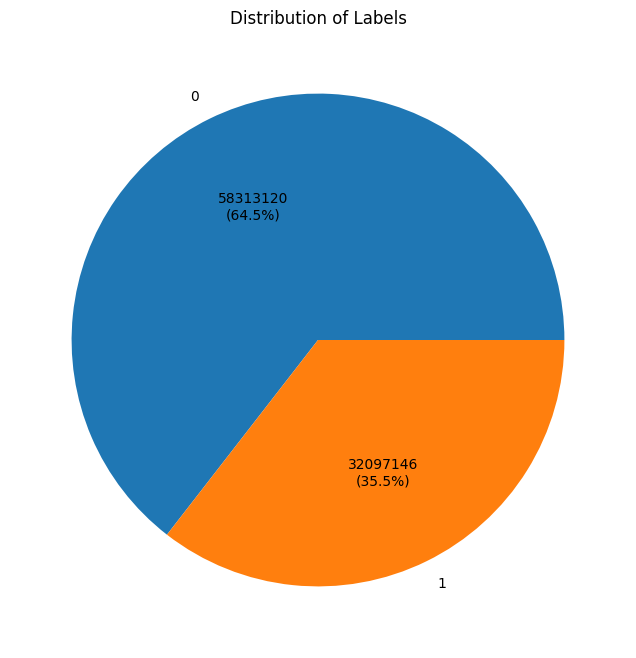

In [16]:
# Count the occurrences of each label
label_counts = df['label'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(label_counts) / 100, p))

# Show the plot
plt.title('Distribution of Labels')
plt.show()

In [17]:
df.columns

Index(['bytes_in', 'bytes_out', 'num_pkts_out', 'num_pkts_in', 'proto',
       'time_start', 'label'],
      dtype='object')

## Construction of Interval Information Granules

### Selecting index using time windows

In [18]:
df.loc[df['time_start'].notna() & (df['time_start'] > 1e12), 'time_start'] //= 1000
df = df.sort_values(by=['time_start'])

In [19]:
perc = 0.8

rows_perc = int(len(df)*perc)

df_test = df.iloc[rows_perc:]
df_train = df.iloc[:rows_perc]

In [20]:
if os.path.exists('./LUFlow/GranulatedData'):
    GRANULATED = True
else:
    GRANULATED = False
    os.makedirs('./LUFlow/GranulatedData')

In [21]:
from tqdm import tqdm

time_slices = [16, 128, 256, 1024, 2048, 3016]

if not GRANULATED:
  matching_indices_slices = {}

  time_start_values = df['time_start'].values
  n = time_start_values

  for ts in tqdm(time_slices):
    
    ts_milli = ts * 1000

    # maximum time limit of the granule
    limit = time_start_values[0] + ts_milli

    # number of groups for time_slice
    num_group = 0
    group_dict = {num_group:[0]}

    for i in range(1, len(n)):
        # if the value of time_start is greater than limit then limit is updated and
        # it is initilized a new group otherwise the index of the row is added to group_dict
        if time_start_values[i] >= limit:
          limit = time_start_values[i] + ts_milli
          num_group += 1

          group_dict[num_group] = [i]
        else:
          group_dict[num_group].append(i)
    
    matching_indices_slices[ts] = group_dict
    del group_dict
    gc.collect()

100%|██████████| 6/6 [03:41<00:00, 36.99s/it]


### Drop Label column

In [22]:
# Separate features (X) and target variable (y)
X_train = df.loc[:, df.columns != 'label']
y_train = df['label']

del df
gc.collect()

0

In [23]:
# Separate features (X) and target variable (y)
X_test = df_test.loc[:, df_test.columns != 'label']
y_test = df_test['label']


del df_test
gc.collect()

0

In [24]:
X_train

,bytes_in,bytes_out,num_pkts_out,num_pkts_in,proto,time_start
53507459,34,29,11,10,6,1593562194
53507746,0,0,1,1,6,1593562273
53048722,0,0,4,0,6,1593562370
53509060,270,191,6,6,6,1593562776
53511717,34,29,11,10,6,1593564035
...,...,...,...,...,...,...
31080032,270,140,4,5,6,1613559691633
31080065,270,191,6,6,6,1613559692831
31080047,1359,745,14,14,6,1613559693347
31080048,270,191,6,6,6,1613559693524


In [25]:
y_train = y_train.to_frame()
y_train

,label
53507459,1
53507746,1
53048722,0
53509060,1
53511717,1
...,...
31080032,1
31080065,1
31080047,1
31080048,1


### Creating interval information granules

with justifiable granularity principle


implementing both 'a' and 'b' to define the frames to include in the granule

In [26]:
import math


columns = ['bytes_in', 'bytes_out', 'num_pkts_out', 'num_pkts_in', 'proto', 'time_start', 'label']


if not GRANULATED:
  alpha = 2.0
  l = 100

  for time_slice in time_slices:
    
    df = pd.DataFrame(columns=columns)
    df.to_csv(f'./LUFlow/GranulatedData/justifiable_granules_{time_slice}.csv', index=False)

    for group in tqdm(matching_indices_slices[time_slice]):

      # obtains index for previous defined groups
      group_indeces = matching_indices_slices[time_slice][group]

      group_data = X_train.iloc[group_indeces]

      N = len(group_data)

      # if the slice has only one element, the granule is the element itself
      if N == 1:
        row = group_data.iloc[0]
        row['label'] = y_train.loc[group_indeces]['label'].iloc[0]
        row = row.to_frame().T

        df_gran = pd.DataFrame(row)
        df_gran.to_csv(f'./LUFlow/GranulatedData/justifiable_granules_{time_slice}.csv', mode='a', index=False, header=False)
        continue
      

      stats = group_data['time_start'].agg(['min', 'max', 'mean'])
      y_min, y_max, m = stats['min'], stats['max'], stats['mean']

      y_max_rel = y_max - y_min

      m_rel = m - y_min

      delta_y = (y_max_rel - m_rel)/l

      V_b_opt, V_a_opt = float('-inf'), float('-inf')
      a_opt, b_opt = None, None

      for h in range(0, l):
        b_rel = m_rel+h*delta_y
        a_rel = m_rel-h*delta_y

        b = y_min + b_rel
        sp_b = math.exp(-alpha*abs(m_rel-b_rel))

        a = y_min + a_rel
        sp_a = math.exp(-alpha*abs(a_rel-m_rel))

        cov_b = ((group_data['time_start'] > m) & (group_data['time_start'] <= b)).sum() / N
        cov_a = ((group_data['time_start'] > a) & (group_data['time_start'] <= m)).sum() / N

        V_b = cov_b*sp_b
        V_a = cov_a*sp_a

        if V_a > V_a_opt:
          a_opt, V_a_opt = a, V_a

        if V_b > V_b_opt:
          b_opt, V_b_opt = b, V_b

      condition = (group_data['time_start'] > a_opt) & (group_data['time_start'] <= b_opt)
      filtered_granule = group_data[condition]

      # Make sure the granule is not empty
      if filtered_granule.empty:
        granule_data_y = y_train.loc[group_indeces]['label']

        # DA DEFINIRE COME TRATTARE IN QUESTO CASO JUSTIFIABLE GRANULARITY
        # row = group_data.iloc[0]
        # row['label'] = granule_data_y.iloc[0]
        index = (group_data['time_start'] - m).abs().idxmin()
        row = group_data.loc[index]
        row['label'] = granule_data_y.iloc[0]

        df_gran = pd.DataFrame([row])
        df_gran.to_csv(f'./LUFlow/GranulatedData/justifiable_granules_{time_slice}.csv', mode='a', index=False, header=False)

        continue  # Skip this group if no data fits the condition

      # Extract the selected rows
      selected_rows = y_train.iloc[filtered_granule.index]['label']

      # # Find the most frequent value (mode)
      most_frequent_value = selected_rows.mode().iloc[0]

      # Assign the modal value to all selected rows
      if len(filtered_granule) == 1:
        row = filtered_granule.iloc[0]
      else:
        row = filtered_granule[['bytes_in', 'bytes_out', 'num_pkts_out', 'num_pkts_in', 'proto']].sum()
        row['time_start'] = filtered_granule['time_start'].iloc[0]
      
      # Vectorized mode calculation
      row['label'] = most_frequent_value

      df_gran = pd.DataFrame([row])
      df_gran.to_csv(f'./LUFlow/GranulatedData/justifiable_granules_{time_slice}.csv', mode='a', index=False, header=False)

      del group_data

  0%|          | 0/663779 [00:00<?, ?it/s]

100%|██████████| 3770/3770 [03:37<00:00, 17.30it/s]


### Training of Random Forest models

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef
from tqdm import tqdm

list_reports = {}
best_models = {}
bcc_reports = {}

mcc_reports = {}

# Random Forest with GridSearchCV
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
rf_model = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf_model, rf_params, cv=10, scoring='accuracy')

training_data, y_train_list, X_train_granule_df = None, None, None

for time_slice in tqdm(time_slices):

  training_data = pd.read_csv(f'./LUFlow/GranulatedData/justifiable_granules_{time_slice}.csv')
  y_train_list = training_data['label']
  X_train_granule_df = training_data.drop(columns=['label'])

  list_reports[time_slice] = {}
  best_models[time_slice] = {}

  rf_grid.fit(X_train_granule_df, y_train_list)
  rf_best_model = rf_grid.best_estimator_

  rf_pred = rf_best_model.predict(X_test)
  report = classification_report(y_test, rf_pred, output_dict=True, zero_division=0)

  tn, fp, fn, tp = confusion_matrix(y_test, rf_pred).ravel()

  # Calculate MCC avoiding overflow
#   numerator = tp * tn - fp * fn
#   terms = [tp + fp, tp + fn, tn + fp, tn + fn]
#   log_denominator = sum(np.log(term) for term in terms if term > 0) 
  
#   if log_denominator > 0:
#       mcc_reports[time_slice] = numerator / np.exp(0.5 * log_denominator)
#   else:
#       mcc_reports[time_slice] = 0  # Use a fallback value for zero/invalid denominato
  mcc_reports[time_slice] = matthews_corrcoef(y_test, rf_pred)

  bcc_reports[time_slice] = (tp/(tp+fn) + tn/(tn+fp))/2

  list_reports[time_slice] = pd.DataFrame(report).transpose()
  best_models[time_slice] = rf_best_model

  del training_data, y_train_list, X_train_granule_df

100%|██████████| 6/6 [3:29:51<00:00, 2098.56s/it]    


In [42]:
# training_data = pd.read_csv(f'../../dataset/LUFlow/GranulatedData/justifiable_granules_16.csv')
# len(training_data[training_data['label'] == 0])

454469

# Model Performance

The performance metrics used by the approach proposed in [8]:
-	Accuracy is the proportion of accurately classified datapoints in the test set in relation to the total number of instances.
-	Precision is the ratio of detected positive cases to all expected positive instances.
-	Recall is the ratio of samples classified as positive to all expected positive instances.
-	F1-score is a harmonic mean of recall and precision.
-	MCC (Matthews Correlation Coefficient) determines the correlation coefficient between the anticipated and actual classifications.
-	BCC (Balanced Accuracy) is used for situations with data imbalance.

In [28]:
# Go up one directory
os.chdir('..')

# Check if 'reports' directory exists, otherwise create it
if not os.path.exists('reports'):
    os.mkdir('reports')

# Check if 'best_models' directory exists, otherwise create it
if not os.path.exists('best_models'):
    os.mkdir('best_models')

In [29]:
import time
import joblib

# string = 'justifiablegranularity_'+str(subset)+'_'+time.strftime("%Y%m%d-%H%M%S")
string = 'justifiablegranularity_2_20241129-000600'

os.mkdir(f'./reports/{string}')
os.mkdir(f'./best_models/{string}')

os.chdir(f'./reports/{string}')

for report in list_reports:
  list_reports[report].to_csv(f'report_{report}.csv')

columns = ['time_slice', 'BCC', 'MCC']
df = pd.DataFrame(columns=columns)
# for bcc, mcc, time_slice in bcc_reports, mcc_reports, time_slices:
for time_slice in time_slices:
  row = {'time_slice': time_slice, 'BCC': bcc_reports[time_slice], 'MCC': mcc_reports[time_slice]}
  row = pd.DataFrame([row])
  row.to_csv('bcc_mcc.csv', mode='a', header=False, index=False)

os.chdir(f'../../best_models/{string}')

for model in best_models:
  joblib.dump(best_models[model], f'model_{model}_{string}.joblib')

In [34]:
for time_slice in time_slices:

    trained_model = joblib.load(f'model_{time_slice}_{string}.joblib')
    params = trained_model.get_params()

    print(f'Model {time_slice}: \n{params}\n')

Model 16: 
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

Model 128: 
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

Model 256: 
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': N

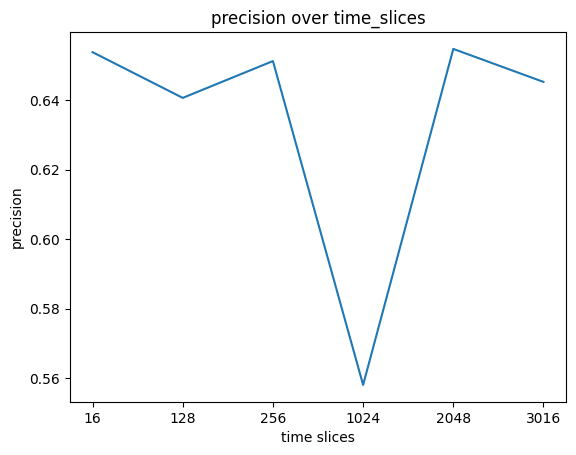

In [30]:
equidistant_x = np.arange(len(time_slices))
feature_to_print = 'precision'

plt.plot(equidistant_x, [list_reports[i].loc['accuracy'][feature_to_print] for i in time_slices])

plt.title(f'{feature_to_print} over time_slices')
plt.xticks(equidistant_x, time_slices)
plt.xlabel('time slices')
plt.ylabel(f'{feature_to_print}')
plt.show()

In [31]:
for time_slice in time_slices:
  print(f'Report {time_slice}: \n{list_reports[time_slice]}\n')
  print(f'BCC {time_slice}: {bcc_reports[time_slice]}\n')
  print(f'MCC {time_slice}: {mcc_reports[time_slice]}')
  print('\n')

Report 16: 
              precision    recall  f1-score       support
0              0.657009  0.991395  0.790286  1.189802e+07
1              0.203329  0.004225  0.008279  6.184034e+06
accuracy       0.653785  0.653785  0.653785  6.537846e-01
macro avg      0.430169  0.497810  0.399282  1.808205e+07
weighted avg   0.501851  0.653785  0.522841  1.808205e+07

BCC 16: 0.49781025968556647

MCC 16: -0.0247315109836871


Report 128: 
              precision    recall  f1-score       support
0              0.653550  0.965879  0.779596  1.189802e+07
1              0.184820  0.014884  0.027549  6.184034e+06
accuracy       0.640640  0.640640  0.640640  6.406404e-01
macro avg      0.419185  0.490382  0.403573  1.808205e+07
weighted avg   0.493245  0.640640  0.522397  1.808205e+07

BCC 128: 0.4903816290347151

MCC 128: -0.0557605187693542


Report 256: 
              precision    recall  f1-score       support
0              0.656805  0.984251  0.787860  1.189802e+07
1              0.257441  0.01